In [142]:
import pandas as pd
import numpy as np
import seaborn as sns

In [143]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train['Species'] = label_encoder.fit_transform(train['Species'])
test['Species'] = label_encoder.fit_transform(test['Species'])

province_encoder = LabelEncoder()

train['Province'] = province_encoder.fit_transform(train['Province'])
test['Province'] = province_encoder.fit_transform(test['Province'])

In [144]:
from sklearn.impute import KNNImputer

geo_imputer = KNNImputer(n_neighbors = 5)

train[['Long', 'Lat']] = geo_imputer.fit_transform(train[['Long', 'Lat']])
test[['Long', 'Lat']] = geo_imputer.fit_transform(test[['Long', 'Lat']])

plot_imputer = KNNImputer(n_neighbors = 5)

train[['Plot']] = plot_imputer.fit_transform(train[['Plot']]).round().astype(int)
test['Plot'] = pd.to_numeric(test['Plot'], errors='coerce')
test[['Plot']] = plot_imputer.fit_transform(test[['Plot']]).round().astype(int)

In [145]:
train['Volume'] = np.pi * (train['Diameter'] / 2) ** 2 * train['Height']
test['Volume'] = np.pi * (test['Diameter'] / 2) ** 2 * test['Height']
test['Basal Area'] = (np.pi * (test['Diameter'] / 2)**2) / 10000
train['Basal Area'] = (np.pi * (train['Diameter'] / 2)**2) / 10000
train['Diameter_Height_Product'] = train['Diameter'] * train['Height']
test['Diameter_Height_Product'] = test['Diameter'] * test['Height']


In [146]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

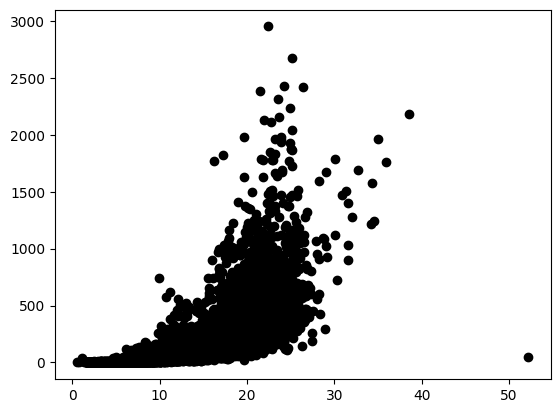

In [147]:
from matplotlib import pyplot as plt
plt.plot(train['Height'], train['Biomass'], 'o', color='black');

In [148]:
print(train.describe())

                Id     Province         Plot         Tree     Species  \
count  6617.000000  6617.000000  6617.000000  6617.000000  6617.00000   
mean   3308.000000     5.282605    22.918241    73.417712    17.94091   
std    1910.307698     2.222968    39.868399   121.171086    10.82784   
min       0.000000     0.000000     1.000000     1.000000     0.00000   
25%    1654.000000     3.000000     5.000000     6.000000     7.00000   
50%    3308.000000     6.000000    18.000000    18.000000    21.00000   
75%    4962.000000     7.000000    23.000000    76.000000    27.00000   
max    6616.000000     8.000000   374.000000   617.000000    33.00000   

          Diameter       Height          Lat         Long      Biomass  \
count  6617.000000  6617.000000  6617.000000  6617.000000  6617.000000   
mean     18.146743    13.806541    48.382348   -84.766887   187.624754   
std      11.313594     6.207416     3.500601    11.334152   280.789898   
min       0.700000     0.600000    43.933000  

In [149]:
print(train.head)

<bound method NDFrame.head of         Id  Province       Year      Location  Plot  Tree  Species  Diameter  \
0        0         0       1979  Lac La biche     8   201       16      21.0   
1        1         0       1979  Lac La biche     8   202       16      23.5   
2        2         0       1979  Lac La biche     8   203       16      23.9   
3        3         0       1979  Lac La biche     8   204       16      21.7   
4        4         0       1979  Lac La biche     8   205       16      23.0   
...    ...       ...        ...           ...   ...   ...      ...       ...   
6612  6612         7        NaN           NaN    13    14        7       9.4   
6613  6613         7        NaN           NaN    23    28        7      18.0   
6614  6614         7  1982-1983           NaN     1     8        9      35.2   
6615  6615         7  1982-1983           NaN     2     2        9      17.4   
6616  6616         7        NaN           NaN     6    11       23      24.2   

      Hei

In [150]:
columns = ['Diameter', 'Height', 'Volume', 'Basal Area', 'Diameter_Height_Product', 'Species', 'Plot', 'Province', 'Long', 'Lat']
X_train, X_test, y_train, y_test = train_test_split(train[columns], train['Biomass'], test_size=0.2, random_state=42)

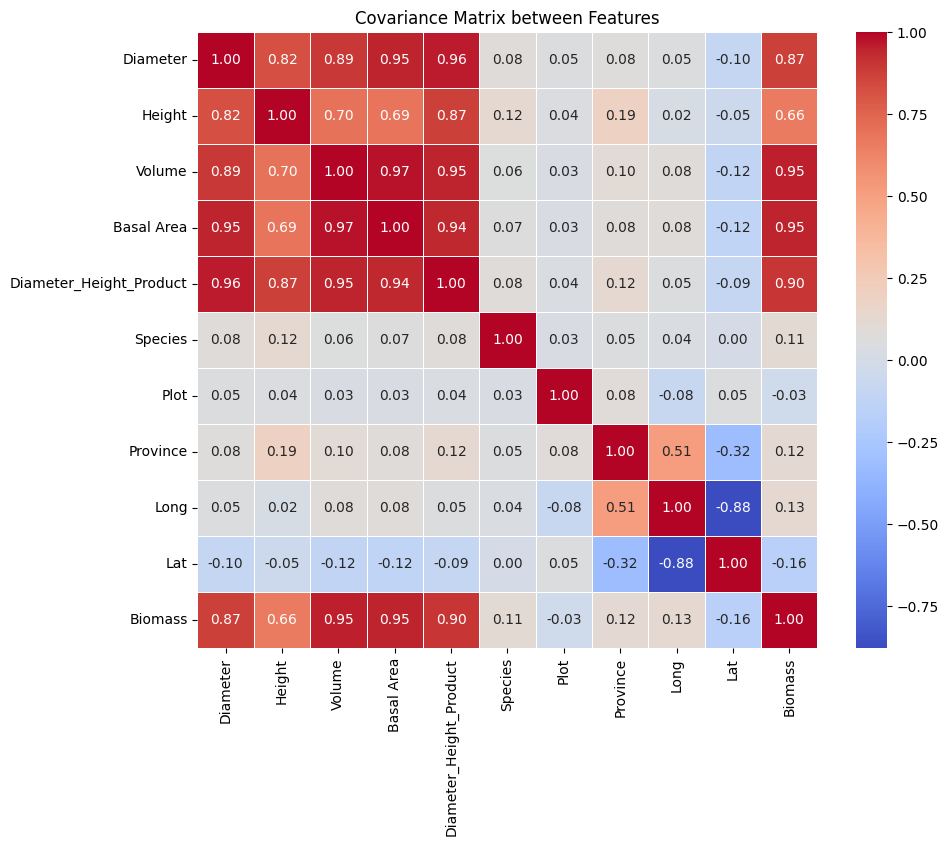

In [151]:
covariance_matrix = train[columns + ['Biomass']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Covariance Matrix between Features')
plt.show()

In [152]:
scoring_method_mape = make_scorer(lambda pred, target: -mean_absolute_percentage_error(pred, target))

def k_fold_fit_and_evaluate(x, y, model, scoring_method=scoring_method_mape, n_splits=5):
    cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    scores = cross_validate(model, x, y, scoring=scoring_method, cv=cv, n_jobs=-1) 
    return scores

In [153]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

models = {
    "RandomForestRegressor": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "GradientBoostingRegressor": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoostRegressor": AdaBoostRegressor(n_estimators=100, random_state=42),
    "MLPRegressor": MLPRegressor(),
    "SVR": SVR()
}

In [154]:
from sklearn.model_selection import GridSearchCV


def iterate_grid_search(model_parameters):
    for model_name, parameters in model_parameters.items():
        model = models[model_name]

        n_splits = 5
        cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)
        grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=-1, 
                                   verbose=10, 
                                   scoring=scoring_method_mape).fit(X_train, y_train) 

        best_score = grid_search.best_score_
        best_params = grid_search.best_params_
        
        print(model_name)
        print("- best_score =", best_score)
        print("best parameters:")
        for k,v in best_params.items():
            print("-", k, v)

In [155]:
model_parameters_RandomForestRegressor = {
    # "RandomForestRegressor": {
    #     "criterion": ["squared_error", "absolute_error"],
    #     "max_depth": [None, 10, 50],
    #     "min_samples_split": [2, 5],
    #     "min_samples_leaf": [2, 4],
    #     "random_state": [42],
    # },
    # "GradientBoostingRegressor": {
    #     "loss": ["squared_error", "absolute_error"],
    #     "learning_rate": [0.1, 0.05],
    #     "n_estimators": [100, 200],
    #     "max_depth": [None, 10, 50],
    #     "min_samples_split": [2, 5],
    #     "min_samples_leaf": [2, 4]
    # },
    #"MLPRegressor": {
    #         
    # },
    # "SVR": {
    # "kernel": ["linear", "poly", "rbf", "sigmoid"],
    # "degree": [2, 3, 4],
    # "gamma": ["scale", "auto"],
    # }
}
iterate_grid_search(model_parameters_RandomForestRegressor)

In [156]:
finalModel = RandomForestRegressor(criterion='absolute_error', max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100, random_state=42)
finalModel.fit(X_train, y_train)
y_pred = finalModel.predict(X_test)
print(mean_absolute_percentage_error(y_pred, y_test))

0.16876092135784326


In [157]:
finalModel.fit(train[columns], train['Biomass'])
y_solution = finalModel.predict(test[columns])

In [158]:
# Save the predictions into the prober submission format
submission = pd.DataFrame({'Id': test['Id'], 'Biomass': y_solution})
submission.to_csv('submission.csv', index=False)